In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import h5py
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FuncFormatter)
from matplotlib.lines import Line2D
import matplotlib.font_manager
import numpy as np

import atlas_mpl_style as ampl
ampl.use_atlas_style(usetex=True)
ampl.set_color_cycle("Paper", 6)

/home/abadea/.local/lib/python3.8/site-packages/atlas_mpl_style/__init__.py:212: UserWarning: No LaTeX installation found -- atlas-mpl-style is falling back to usetex=False
  _warn.warn(


In [2]:
data = {
    "inFileName" : "/data/karri/smartPix/dataset-lowpt/h5FromRaw/pixel_clusters_d17201.h5"
}
with h5py.File(data["inFileName"],"r") as f:
    x = np.array(f['data'])
    y = np.array(f['labels'])

    # x-entry, y-entry, z-entry, n_x, n_y, n_z, number_eh_pairs, y-local, pt
    x_entry = y[:,0]
    y_entry = y[:,1]
    z_entry = y[:,2]
    nx = y[:,3]
    ny = y[:,4]
    nz = y[:,5]
    number_eh_pairs = y[:,6]
    ylocal = y[:,7]
    data["pT"] = y[:,8]

    # calculated
    cotAlpha = nx/nz
    cotBeta = ny/nz
    times = np.linspace(200, 4000, 20)

    data["eta"] = -np.log(abs(np.tan((1/2)*(np.arctan2(nz,nx))))) #theta = alpha;all negative values go to NaN w/np.log; abs value prevents this
    data["phi"] = (np.arctan2(nz,ny)) #to degrees *(180/torch.pi) # phi=beta

In [26]:
# read in the data
models = {
    "DNN" : {
        "inFileName" : "/data/ckumar/evaluations/pixel_clusters_d17201_Model_morelayers_0.01lr-32b.h5",
        "color" : "blue",
    },
    "CNN" : {
        "inFileName" : "/home/abadea/smartpix/cnn/checkpoints/training_2023.11.16.00.13.37/evaluation_results.h5",
        "color" : "green",
    }
}
vars = [["eta", "$\eta$"], ["phi", "$\phi$"], ["pT", "p$_{\mathrm{T}}$ [GeV]"]]
for key, val in models.items():   
    with h5py.File(val["inFileName"]) as f:
        temp = np.array(f['outputs'])
        for iL, [var, xlabel] in enumerate(vars):
            val[var] = temp[:,iL]

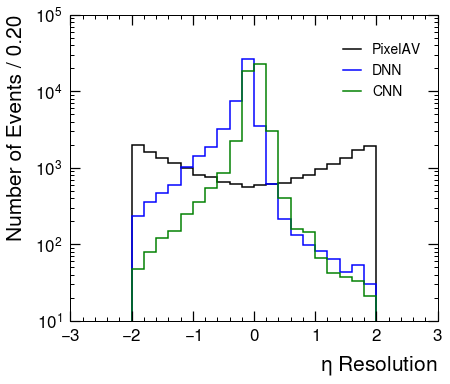

<Figure size 799.992x599.976 with 0 Axes>

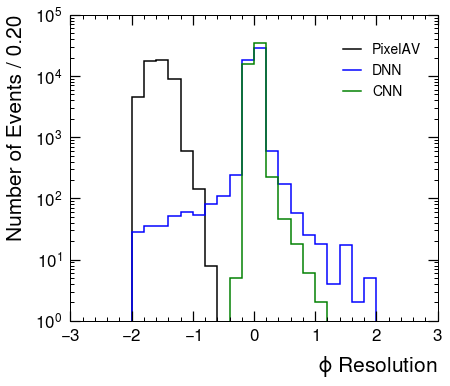

<Figure size 799.992x599.976 with 0 Axes>

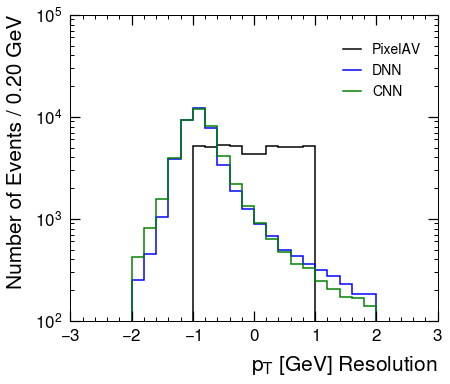

<Figure size 799.992x599.976 with 0 Axes>

In [30]:
# pick up the bins and the y
bins = np.linspace(-2,2,21)
binW = bins[1]-bins[0]
lw=1.5
rasterized = False
resolution = True

for iL, [var, xlabel] in enumerate(vars):
    
    # make plot
    fig = plt.figure(figsize=(6, 5))
    ax = plt.axes([0.1, 0.1, 0.85, 0.85])

    # draw data
    ax.hist(data[var], 
        bins=bins, 
        alpha=1.0, 
        lw=lw,
        ls="-",
        histtype="step",
        label="PixelAV",
        color="black",
        rasterized=rasterized)

    for key, val in models.items():
        
        # draw prediction
        ax.hist((val[var]-data[var])/data[var] if resolution else val[var], 
            bins=bins, 
            alpha=1.0, 
            lw=lw,
            ls="-",
            histtype="step",
            label=key,
            color=val["color"],
            rasterized=rasterized)

    # enable legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor(), ls=h.get_linestyle()) for h in handles]
    ax.legend(new_handles,
              labels,
              title="",
              title_fontsize="13",
              ncol=1,
              framealpha=0.0,
              prop={'size': 14},
              bbox_to_anchor=(0.54, 0.45, 0.45, 0.5),
              handlelength=1.25)
    
    # set labels
    ax.set_xlabel(xlabel + (" Resolution" if resolution else ""), fontsize=21, labelpad=9, horizontalalignment='right', x=1.0)
    ax.set_ylabel(f"Number of Events / {binW:.2f}" + (" GeV" if "GeV" in xlabel else ""), fontsize=21, labelpad=9, horizontalalignment='right', y=1.0)
    
    # set limits
    # ax.set_xlim(0,3500)
    # ax.set_ylim(0, 0.22)
    
    # tick params
    tick_params_major = {"which"     : "major",
                         "length"    : 10,
                         "width"     : 1.25,
                         "direction" : "in",
                         "right"     : True,
                         "top"       : True,
                         "labelsize" : 17,
                         "pad"       : 8}
    tick_params_minor = {"which"     : "minor",
                         "length"    : 4,
                         "width"     : 1,
                         "direction" : "in",
                         "right"     : True,
                         "top"       : True,
                         "labelsize" : 15}
    
    # ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    # ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(**tick_params_major)
    ax.tick_params(**tick_params_minor)
    plt.locator_params(axis='y', nbins=8)
    plt.locator_params(axis='x', nbins=8)
    
    # save
    plt.yscale("log")
    plt.show()
    outFileName = var+".pdf"
    plt.savefig(outFileName, bbox_inches="tight") # _noFirstLayer